# Discrete Math meets Deep Learning

I  assume you are here because you saw a lecture of mine or a recording of one. If you haven't seen any, you might feel a bit lost, but you can check for a link on [GitHub repository this notebook is hosted](https://github.com/satuelisa/DiscreteMath/tree/master/demo) on for more info.

Occasionally, we load the libraries with `import`. If you do not have them at your end and you want to run this on your own computer, make sure you install Python 3 first and then use `pip` to gather the rest.

If you have no idea how to locally interact with this kind of a file, it's called a Jupyter notebook and it is easy enough to install on your own computer (it will open in your browser).

Now, we decide how many cities we are working with.

In [1]:
n = 5 # a small default
assert n > 2 # we need at least three for this to make sense
print(f'Working with a TSP of {n} cities')    

Working with a TSP of 5 cities


Then some parameters for the visualizations we will be making. Do not worry about understanding these unless you are a programmer, but play with them to see what happens if you change the numbers :)

In [2]:
from math import sqrt, log, ceil, exp, fabs # mathematical routines
unit = 8
width = int(n * sqrt(n))
wunit = (width / n) * unit
radius = 1 / n
magn = int(ceil(log(n, 2)))
significant = 0.01
gns = max(50, 300 - 20 * int(log(n, 2))) if n <= 30 else 20 # node size for graphs
tns = max(150, 400 - 20 * int(log(n, 2))) if n < 5 else 20 # node size for trees

In order to *measure time*, let's have a small auxiliary routine to print that out when we want to see it.

In [3]:
from time import time
def timestamp(start):
    ms = 1000 * (time() - start)
    print(f'That took {ms:.2f} ms of runtime')

OK, now we are ready to roll. To build the graph, we are going to use **Euclidean distances** as the costs of the edges.

In [4]:
def eucl(p1, p2):
    (vx, vy) = p1
    (wx, wy) = p2
    dx = vx - wx # horizontal difference
    dy = vy - wy # vertical difference
    return sqrt(dx**2 + dy**2) # remember Pythagoras?

Let's build a graph. We *could* of course do the creation of the graph using a library routine from networkx, but we *learn* more if we do it step by step.

In [5]:
from networkx import Graph, draw, relabel_nodes
G = Graph() # storage for the graph
gpos = dict() # storage for the vertex positions
v = 0

from random import random, shuffle, randint # pseudo-random number generation
while v < n: # add a total of n vertices called 0, 1, 2, ..., n - 1
    # position each vertex pseudo-randomly in a unit square
    x = random() # horizontal position
    y = random() # vertical position
    p = (x, y)
    close = False
    for w in G.nodes(): # check that it is not too close
        distance = eucl(p, gpos[w])
        if distance < radius:
            close = True
            break
    if not close:
        G.add_node(v)
        gpos[v] = (x, y)
        v += 1

Now we have nodes and we know their positions. We need to add the edges. While at it, we can figure out what is the lowest and the highest cost of a single edge in the graph we have created. Also note that no solution could ever cost more than **all** the edges.

In [6]:
low = sqrt(2) # the highest possible Euclidean distance in a unit square
high = 0 # the lowest possible distance
edgecosts = dict()
for v in gpos: # for each vertex
    for w in gpos: # for each other vertex
        if v == w:
            continue # skip self
        d = eucl(gpos[v], gpos[w])
        G.add_edge(v, w, cost = d)
        edgecosts[(v, w)] = d
        edgecosts[(w, v)] = d
        low = min(low, distance) # figure out the minimum edge cost
        high = max(high, distance) # as well as the maximum
# view the min-max edgecosts at two-decimal precision
print(f'The minimum single-edge cost is {low:.2f} and the maximum is {high:.2}')
worst = sum(edgecosts.values()) / 2 

The minimum single-edge cost is 0.26 and the maximum is 0.26


We should take a moment to admire the creation. To draw it, first we set up how we want the visualization to look.

In [7]:
opt = { 'node_color': 'white', 'font_color': 'black' }
opt['with_labels'] = n <= 30
opt['node_size'] = gns
opt['width'] = max(4 - magn, 1)
import matplotlib.pyplot as plt # for the drawings
plt.rcParams['figure.figsize'] = (unit, unit) # big figure

Now, in case you want to experiment with really big graphs later on, we might not want to *draw* those since it will get messy. So I will put a little safeguard here and there in case we forget there is heavy calculations ahead and input a value for `n` that is a bit too big to swallow.

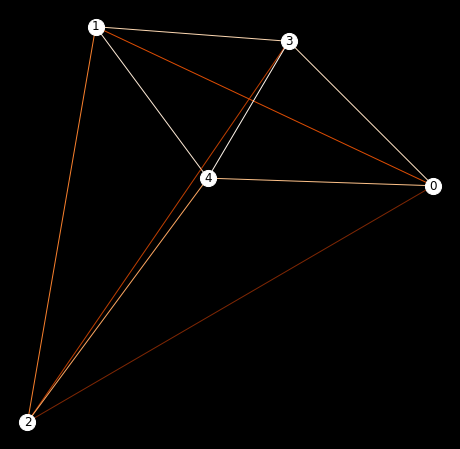

In [8]:
if n <= 150:
    fig, ax = plt.subplots() # create an image to draw onto
    draw(G, pos = gpos, # place each vertex in the unit square using its coordinates
         edge_cmap = plt.get_cmap('Oranges'), # use tones of orange to color the edges
         edge_color = [ edgecosts[(v, w)] for v, w in G.edges() ], # the tone of each depends on its cost
         **opt) # use the options above
    ax.set_facecolor('black') # make it a black background
    fig.set_facecolor('black')
    ax.axis('off') # no axis needed
    plt.show()
    plt.close()

For the **exhaustive** solution, we need to explore the tree of all the possible orderings of the visits. Here is a home-made implementation of a data structure to take care of that part. Studying its inner workings can be interesting for students of data structures or discrete mathematics ;) Others can just take this at face value and skip ahead.

In [9]:
class Node: # now, consider all the possible visitation orders as a tree

    def __init__(self, label, parent = None, depth = 0): # create an empty node
        self.value = label # store the value
        self.parent = parent # root has none
        self.children = None # leaves have none
        self.depth = depth # the root is at zero
        self.height = None
        self.x = None
        self.y = None
        self.path = ''
        self.cost = 0
        self.total = 0
        self.label = None

    def adjust(self): # set values for height
        tallest = [ child.adjust() for child in self.children ] if self.children is not None else [ 0 ]
        self.height = 1 + max(tallest) # leaves have height one
        return self.height

    def __str__(self): # print the node (recursively the tree)
        prefix = ' ' * self.depth
        below = '\n'.join(str(child) for child in self.children) if self.children is not None else ''
        return f'{prefix}{self.path}\n{below}'.rstrip()

    def __repr__(self):
        return str(self) # when asked to represent, use the above format

    def present(self): # what values are already present at or above this one
        above = self.parent.present() if self.parent is not None else set()
        return { self.value } | above

    def permute(self, values, source, root, best):
        if self.parent is not None: # not the root
            self.path = self.parent.path + '.' + str(self.value)
            # the cost of the edge from the parent to this one in the graph
            self.cost = source[(self.value, self.parent.value)]
            self.total = self.cost + self.parent.total
        else:
            self.path = str(self.value)
        pending = sorted(list(values - self.present())) # skip those already present
        if len(pending) == 0: # nothing left (a leaf)
            closing = source[(self.value, root.value)]
            self.total += closing # close the loop
            return min(self.total, best)
        d = self.depth + 1 # the children will be one level deeper
        self.children = [ Node(value, parent = self, depth = d) for value in pending ]
        below = values - { self.value }
        for child in self.children: # continue recursively
            best = min(best, child.permute(below, source, root, best))
        return best

    def position(self, ltarget, ptarget, xr, y, dy):
        self.label = f'{self.path} = {self.total:.2f}' # make a label with total cost
        ltarget[self.path] = self.label
        (xlow, xhigh) = xr
        self.x = (xlow + xhigh) / 2 # horizontally in the middle
        self.y = y # vertical position
        ptarget[self.label] = (self.x, self.y) # associate positions to the labels
        if self.children is not None:
            xspan = xhigh - xlow
            xa = xspan / len(self.children) # horizontal allocation per child
            for child in self.children:
                child.position(ltarget, ptarget, (xlow, xlow + xa), y - dy, dy)
                xlow += xa


    def join(self, graph): # add nodes as vertices to draw with networkx
        graph.add_node(self.path)
        if self.children is not None:
            for child in self.children:
                child.join(graph)

    def connect(self, graph): # add connections as edges to draw with networkx
        if self.parent is not None:
            v = self.label
            w = self.parent.label
            graph.add_edge(v, w, cost = self.cost)
        if self.children is not None:
            for child in self.children:
                child.connect(graph)

    def cheapest(self, best):
        if self.children is None: # at a leaf
            return min(self.total, best)
        else: # not at a leaf yet
            return min([ child.cheapest(best) for child in self.children ])

Of course we want to draw this as well, since we are learning about how things work. First we will adjust the drawing options to better match this scenario.

In [10]:
opt['with_labels'] = n < 5
opt['font_color'] = 'cyan'
opt['node_size'] = tns

Then another little safeguard (beware the combinatorial explosion).

The cheapest (exhaustive) route edgecosts 2.36
That took 0.37 ms of runtime


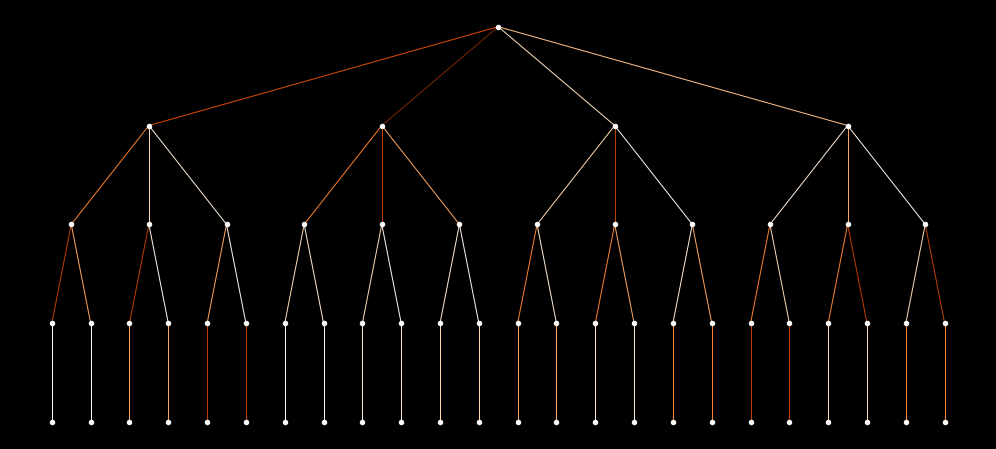

In [11]:
if n < 11: # too slow for larger graphs
    # note that it does not matter where we start since it is a cycle
    start = time()
    groot = Node(0) # we can start at zero w.l.o.g.
    gbest = groot.permute({ v for v in range(n) }, edgecosts, groot, worst)
    print(f'The cheapest (exhaustive) route edgecosts {gbest:.2f}')
    timestamp(start)
    groot.adjust()
    T = Graph() # we make a graph of it so we can draw it the same way
    groot.join(T) # create vertices to represent the nodes
    labels = dict()
    tpos = dict()
    plt.rcParams['figure.figsize'] = (wunit, unit) # big figure
    groot.position(labels, tpos, (0, w), 1, 1 / (n + 1)) # label and position the nodes with
    L = relabel_nodes(T, labels)
    groot.connect(L) # add edges to represent the branches and match the edgecosts
    if n < 7: # makes no sense for large n to draw the trees
        fig, ax = plt.subplots()
        draw(L, pos = tpos, # using the tree positions
             edge_cmap = plt.get_cmap('Oranges'),
             edge_color = [ data['cost'] for v, w, data in L.edges(data = True) ], **opt)
        ax.set_facecolor('black')
        fig.set_facecolor('black')
        plt.show()
        plt.close()        

Remember to be smart and prune branches that cost more than the best one seen thus far. We will be object-oriented and inherit a new class from the `Node` defined above. Do not worry about what exactly this is unless you are supposed to know OOP; we are just adding a bit of new functionality to what we defined above to make it act smarter.

In [12]:
class Smart(Node):

    def __init__(self, label, parent = None, depth = 0):
        super().__init__(label, parent, depth)
        self.complete = False

    def role(self, target):
        # complete leaves are 1, incomplete leaves are 0, internals are -1
        target[self.label] = 1 * self.complete if self.children is None else -1
        if self.children is not None:
            for child in self.children:
                child.role(target)

    def permute(self, values, source, root, best): # redefine how to proceed
        if self.parent is not None:
            self.path = self.parent.path + '.' + str(self.value)
            self.cost = source[(self.value, self.parent.value)]
            self.total = self.cost + self.parent.total
            if self.total > best: # already more expensive, makes no sense to continue
                self.path += str(self.value) # leave early
                return best # this becomes an incomplete route if not a leaf yet
        else:
            self.path = str(self.value)
        pending = sorted(list(values - self.present())) # skip those already present
        if len(pending) == 0: # nothing left (a leaf)
            closing = source[(self.value, root.value)]
            self.total += closing
            self.complete = True
            return min(self.total, best)
        d = self.depth + 1
        self.children = [ Smart(value, parent = self, depth = d) for value in pending ]
        below = values - { self.value }
        for child in self.children:
            best = min(best, child.permute(below, source, root, best))
        return best

Gonna fiddle with the display options again. You can adjust these to your liking in case you want the circles to be pink or the labels to be smaller.

In [13]:
opt['font_color'] = 'cyan'
opt['font_size'] = 12

A safeguard and then we draw.

The cheapest (pruned) route edgecosts 2.36
That took 0.25 ms of runtime


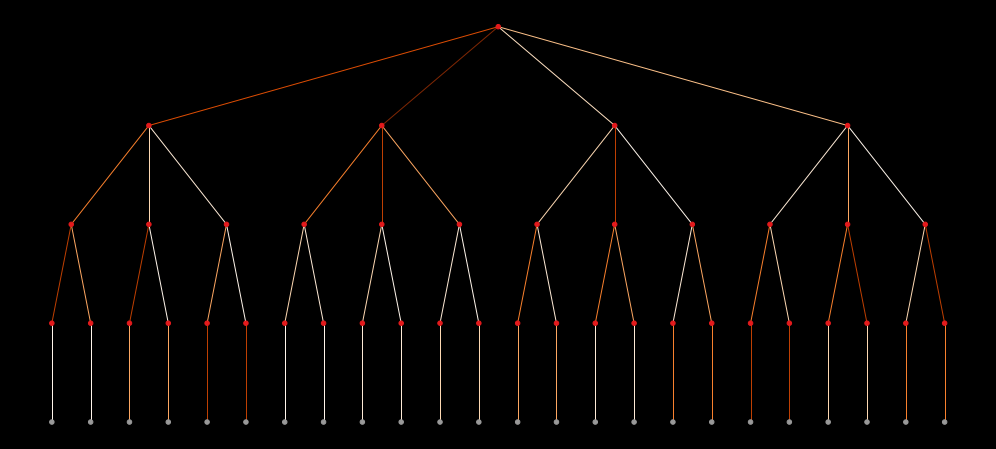

In [14]:
if n < 13:
    start = time()
    sroot = Smart(0)
    sbest = sroot.permute({ v for v in range(n) }, edgecosts, sroot, worst)
    print(f'The cheapest (pruned) route edgecosts {sbest:.2f}')
    timestamp(start)
    assert fabs(gbest - sbest) < significant
    sroot.adjust()
    P = Graph()
    sroot.join(P)
    h = sroot.height
    sroot.position(labels, tpos, (0, w), 1, 1 / (n + 1)) # label and position the nodes with
    Q = relabel_nodes(P, labels)
    sroot.connect(Q) # add edges to represent the branches and match the edgecosts
    del opt['node_color']
    if n < 7:
        complete = dict()
        sroot.role(complete)
        nodecolor = [ complete[v] for v in Q.nodes() ] # intermediate, full solution or pruned
        fig, ax = plt.subplots()
        draw(Q, pos = tpos,
             node_color = nodecolor,
             cmap = plt.get_cmap('Set1'),
             edge_cmap = plt.get_cmap('Oranges'),
             edge_color = [ data['cost'] for v, w, data in Q.edges(data = True) ], **opt)
        ax.set_facecolor('black')
        fig.set_facecolor('black')
        ax.axis('off')
        plt.show()
        plt.close()        

If `n` is small, it is not often that branches get pruned, but with larger quantities it gets more common.

So, now, idea number one to save time: *self-avoiding random walks*. To start with, we could use an auxiliary routine to tell us how much a route we have come up with actually costs.

In [15]:
def cost(G, r):
    acc = 0 # accumulate the cost here
    p = 1 # by traversing the route
    while p < len(r):
        source = r[p - 1]
        target = r[p]
        d = G.get_edge_data(source, target)
        assert 'cost' in d
        acc += d['cost']
        p += 1
    return acc

Now we can make some random walks and see how bad they are (if our `n` was small enough for us to see the optimal cost).

In [16]:
start = time()
route = [ v for v in range(n) ]
replicas = 10 * magn
rbest = worst
bestwalk = None
# let's remember some of these for later
memories = dict()
for replica in range(replicas): # try several times
    shuffle(route) # a new permutation
    cycle = route + [ route[0] ] # close the cycle
    c = cost(G, cycle)
    if c < rbest:
        rbest = c
        bestwalk = cycle.copy()
        memories[f'BRW'] = bestwalk
    if replica < 5:
        memories[f'RW{replica}'] = cycle.copy()
print(f'The cheapest random walk costs {rbest:.2f} (over {replicas} attempts)')
timestamp(start)  

The cheapest random walk costs 2.36 (over 30 attempts)
That took 0.36 ms of runtime


Of course I want to draw the best of these just to see the mess I have made. So let us restore some drawing options to go back to drawing graphs instead of trees. 

In [17]:
plt.rcParams['figure.figsize'] = (unit, unit) # restore some of these
opt['node_size'] = gns
opt['node_color'] = 'white'
opt['with_labels'] = n <= 30
opt['font_color'] = 'black'      

Also, in order not to lose the graph itself, we need a *copy* of it so we can get rid of all the edges that are not part of the random walk. Then, when we draw the rest, we just see the route we have created.

In [18]:
def used(r):
    u = set()
    for p in range(len(r)  - 1):
        a = r[p]
        b = r[p + 1]
        u.add((a, b))
        u.add((b, a))
    return u

W = G.copy() # make a copy
removed = G.edges() - used(bestwalk)
W.remove_edges_from(removed)             

A safeguard and then we draw.

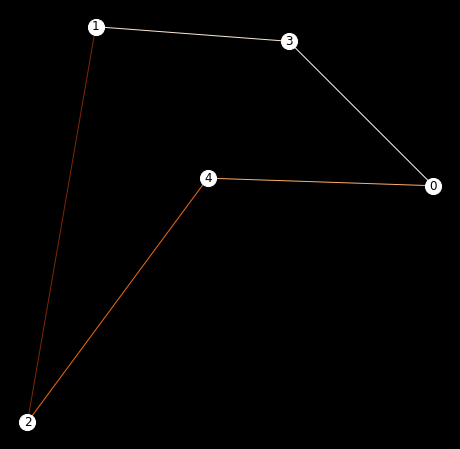

In [19]:
if n <= 100:
    fig, ax = plt.subplots()
    draw(W, pos = gpos,
         edge_cmap = plt.get_cmap('Oranges'),
         edge_color = [ edgecosts[(v, w)] for v, w in W.edges() ],
         **opt)
    ax.set_facecolor('black')
    fig.set_facecolor('black')
    ax.axis('off')
    plt.show()
    plt.close()  

The next idea was starting with a minimum spanning tree (MST). We shall recurr to Kruskal's algorithm (a very didactive implementation, no fancy optimizations here).

In [20]:
from collections import defaultdict # easy storage
import operator # for getting extrema from dictionaries
start = time()
mst = set()
components = dict() # connected-component storage
mstcost = 0 # cost accumulator
neighbors = defaultdict(set)
candidates = edgecosts.copy()
while len(candidates) > 0: # Kruskal's algorithm for MST
    cheapest = min(candidates.items(), key = operator.itemgetter(1))[0]
    (v, w) = cheapest
    value = edgecosts[cheapest]
    del candidates[cheapest] # remove the processed edges
    connected = components.get(v, {v})
    if w not in connected:
        mst.add(cheapest) # use this edge
        neighbors[v].add(w)
        neighbors[w].add(v)
        mstcost += value
        combination = connected.union(components.get(w, {w}))
        if len(combination) == n: # everyone is now connected
            break
        for u in combination:
            components[u] = combination
print(f'The minimum spanning tree costs {mstcost:.2f}')     

The minimum spanning tree costs 1.48


Again, if we make a copy of the graph and strip it down so that only the edges included in the MST remain, we get to visualize the result.

The idea with making an MST is running it back and forth to make a tour that closes but makes too many intermediate visits. We will use depth-first search (DFS) for this purpose.

In [21]:
bf = []
visited = set()

def dfs(v):
    global bf, neighbors, visited
    bf.append(v)
    visited.add(v)
    cand = neighbors[v] - visited # unvisited
    for w in cand:
        dfs(w)
        bf.append(v)
start = time()
dfs(0)
if n <= 10:
    print('Back and forth', bf)
bfcost = cost(G, bf)
print(f'The back-and-forth MST costs {bfcost:.2f}')
timestamp(start)                

Back and forth [0, 3, 4, 1, 4, 2, 4, 3, 0]
The back-and-forth MST costs 2.95
That took 0.14 ms of runtime


Since this in infeasible as a solution because of the repeated visits, we give kudos to the Euclidean distance that satisfies the triangle inequality and happily skip ahead whenever we face the need to backtrack.

In [22]:
start = time()
prev = 0 # start at zero again
st = [ 0 ]
for cand in bf:
    if cand not in st: # skip ahead if already visited
        st.append(cand)
st.append(0) # close the loop
if n <= 10:
    print('Straightened out', st)
for i in range(n):
    assert i in st
scost = cost(G, st)
print(f'The straightened-out MST cycle costs {scost:.2f}')
timestamp(start)
memories['MST'] = st 

Straightened out [0, 3, 4, 1, 2, 0]
The straightened-out MST cycle costs 2.47
That took 0.28 ms of runtime


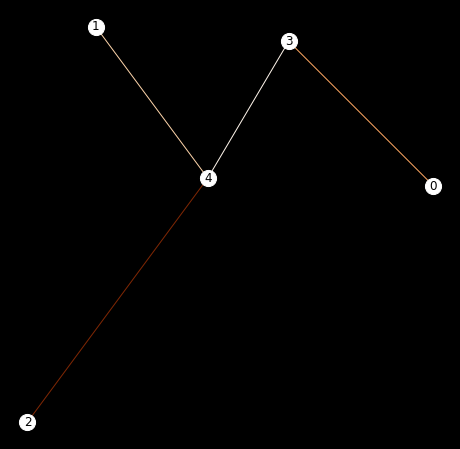

In [23]:
M = G.copy() # make a copy
removed = G.edges() - mst
M.remove_edges_from(removed)
if n <= 150:
    fig, ax = plt.subplots()
    draw(M, pos = gpos,
         edge_cmap = plt.get_cmap('Oranges'),
         edge_color = [ edgecosts[(v, w)] for v, w in M.edges() ],
         **opt)
    ax.set_facecolor('black')
    fig.set_facecolor('black')
    ax.axis('off')
    plt.show(f'mst{n}.png')
    plt.close()                       

To see what this looks like, we will strip edges off yet another copy of the original graph.

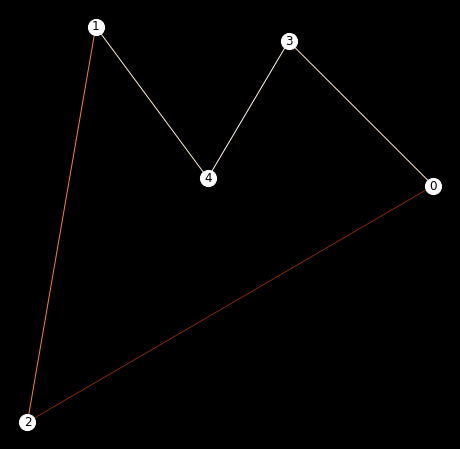

In [24]:
S = G.copy() # make a copy of the graph
S.remove_edges_from(G.edges() - used(st))
if n <= 150:
    fig, ax = plt.subplots()
    draw(S, pos = gpos,
         edge_cmap = plt.get_cmap('Oranges'),
         edge_color = [ edgecosts[(v, w)] for v, w in S.edges() ],
         **opt)
    ax.set_facecolor('black')
    fig.set_facecolor('black')
    ax.axis('off')
    plt.show()
    plt.close()           

Fancier people have better ideas on how to build an MST-based route that lower that upper bound down to 1.5 times the optimum; you can check out the [Christofides algorithm](https://en.wikipedia.org/wiki/Christofides_algorithm) if you want to see how. 

For the local search, we wanted the 2-opt heuristic that takes two edges *(a, b)* and *(c, d)* along the route and then then switched it around going from *a* to *c*, then backwards the original route from *b* to *c* and then continue from *b* to *d*, after which the rest of the route is as before. The result here is that the edges *(a, b)* and *(c, d)* were removed and in their place we now have the edges *(a, c)* and *(b, d)*, so if the sum of the costs of the former exceed that of the latter, we win a little.

In [25]:
def twoopt(r):
    n = len(r)
    f = randint(1, n - 2) # first cut
    s = randint(f + 1, n - 1) # second cut
    start = r[:f]
    middle = r[f:s] # to invert
    finish = r[s:]
    assert len(start) > 0 and len(middle) > 0 and len(finish) > 0
    return start + middle[::-1] + finish   

Since the way we are thinking this requires the two edges to be in the middle of the route instead of at the end of the beginning, we can also just roll the route around since it is a cycle and it does not *really* matter where we start.

In [26]:
def roll(r):
    k = len(r)
    assert r[0] == r[-1]
    offset = randint(1, k - 2)
    assert offset < len(r)
    rolled = r[offset:-1] + r[:offset]
    return rolled + [ rolled[0] ] # close it back

def restore(r):
    if r[0] == 0:
        assert r[-1] == 0
        return r # nothing to do here
    assert r[0] == r[-1]
    zero = r.index(0)
    unrolled = r[zero:-1] + r[:zero] + [0]
    return unrolled        

Our final touch to clean it out with 2-opt use *local search* to exchange some of those bad shortcuts for better ones using 2-opt and rolling in between.

We will use **simulated annealing** that lets us move from the *current* solution to a worse one, so we must keep at all times a copy of the *best* solution we have seen thus far so that we never lose that upper bound of being no more than twice above the cost of the MST.

You can mess with the initial temperature `T`and the cooling schedule `eps` to alter the probability with which worse solutions are accepted. Changing the `maximum` affects the amount of iterations that the search is allow to "stall" without improvement.

In [27]:
def simAnn(G, current, stuck, maximum, quiet = False, \
           T = 1000, cooling = 0.999, eps = 0.01, target = None, cap = 0):
    stalled = 0
    stable = 0
    cheapest = current.copy()
    lcost = ccost = cost(G, current)
    i = 0
    while stalled < maximum and T > eps:
        assert current[0] == current[-1] == 0
        assert len(current) == n + 1
        modified = restore(twoopt(roll(current)))
        mcost = cost(G, modified)
        d = ccost - mcost
        if mcost < lcost: # a new low (a good thing here)
            if target is not None and len(target) < cap: # store this
                target.add(tuple(current)) # lists cannot go into set
            if not quiet:
                print(f'New low at {mcost:.2f} on iteration {i} at temp {T:.2f}')
            cheapest = modified.copy()
            lcost = mcost
            if d > eps:
                stable += 1
                if stable > stuck:
                    stalled = maximum
                    continue
            else:
                stable = 0 # notable improvement
        threshold = exp(d / T) # probability
        i += 1
        if random() < threshold: # accept
            ccost = mcost
            current = modified
            if d > 0: # it was better
                T *= cooling # get stricter
                stalled = 0
                continue
        stalled += 1
    return cheapest   

Let's try it.

In [28]:
start = time()
# start with a copy of the straightened-out route
assert st[0] == st[-1] == 0
cheapest = simAnn(G, st.copy(), magn, 200 * magn)
memories['SA'] = cheapest
timestamp(start)   

New low at 2.36 on iteration 20 at temp 994.01
That took 429.30 ms of runtime


Finally, we can look at the fruit of our labor.

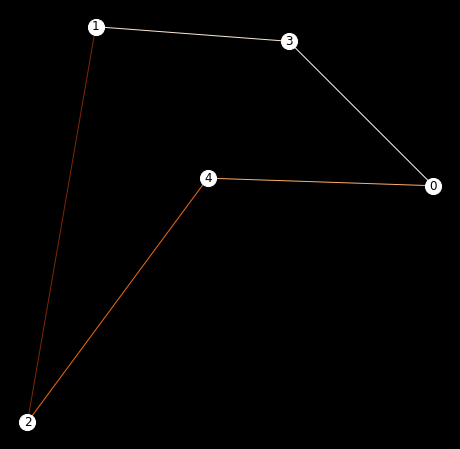

In [29]:
if n <= 150:
    F = G.copy() # make a copy of the graph
    F.remove_edges_from(G.edges() - used(cheapest))
    fig, ax = plt.subplots()
    draw(F, pos = gpos,
         edge_cmap = plt.get_cmap('Oranges'),
         edge_color = [ edgecosts[(v, w)] for v, w in F.edges()  ],
         **opt)
    ax.set_facecolor('black')
    fig.set_facecolor('black')
    ax.axis('off')
    plt.show()
    plt.close()    

All of this is nice and easy when we know the cost of each edge. What if **we didn't** but we could only observe total route costs? Could we *infer* the structure of the graph?

Let's use **deep learning** to find out. We need to make a dataset of tons of routes. Then we train the model to tell the cheap ones apart from the expensive ones. We will *never* show it the edges. Only visit orders and total costs.

The routes themselves would be very **bad** inputs (random orderings), so we should insteadmatch the inputs to the vertices and store at which _position_ each vertex is visited, assuming that 0 is visited first (this way we do not have to worry about the same route with a different "rotation" showing up multiple times in the dataset). We can convert the route into a position listing as follows:    

In [30]:
def index(r):
    pos = dict()
    i = 0
    for v in r[:-1]:
        pos[v] = i
        i += 1
    zero = pos[0] # make this first
    output = [0]
    for v in range(1, n):
        p = pos[v]
        if p > zero: # it came AFTER zero
            output.append(p - zero)
        elif p < zero: # it came BEFORE zero
            output.append(zero + p)
    return output  

In [31]:
from math import factorial

goal = min(500, round(3 * factorial(n - 1) / 4))
start = time()
routes = set()
half = goal // 2
# make roughly half "good ones"
print('Generating probable "good" routes')
stuck = 0
prev = 0
while len(routes) < half and stuck < 10: # make some with local search
    assert st[0] == st[-1] == 0
    simAnn(G, st.copy(), magn, 200 * magn, quiet = True, target = routes, cap = half)
    present = len(routes) # how many do we have
    print(f'At {present} out of {half}')
    if present == prev:
        stuck += 1 # do not try forever
    prev = present
print('Good ones done')
goal = max(present, goal) # if we already have more, match that               

Generating probable "good" routes
At 2 out of 9
At 3 out of 9
At 5 out of 9
At 6 out of 9
At 7 out of 9
At 9 out of 9
Good ones done


So, normally one needs a lot of data, but this is a class demonstration so we do not want the data generation to take an eternity. Note that we cannot make more data than there are possible routes in existence, so we are *bound from above* by the factorial of `n - 1` (remember that we **fixed** 0 to be the first one).

This means that what follows is **very silly** for small values of `n` like the default, as that is meant to generate all the illustrations above. Scroll up, set `n = 15` or so, and then run the code again to get down here before you continue.

We also need to **balance** our data set, making half of the routes "cheap" and the other half "expensive". We can use local search for the former and random walks for the latter and be able to expect such a differentiation.

Now we add the bad (expensive) ones.

In [32]:
# the other half "bad ones" (random walks)
# will need to start at zero, too
# otherwise we get leakage
print('Generating probable "bad" routes')
while len(routes) < goal:
    shuffle(route) # we can use one we already had and mix it
    routes.add(tuple(restore(route + [ route[0] ])))
print('Data generation ready')
timestamp(start)
routes = list(routes)  

Generating probable "bad" routes
Data generation ready
That took 2500.06 ms of runtime


We need to make sure these are randomly ordered to not leak any unintended info by the order in which we feed them to the model.

In [33]:
import numpy as np
shuffle(routes) # randomize the order (RERUN from here on if you encounter imbalance)
costs = [ cost(G, r) for r in routes ] # route costs 

We have a bunch of routes. We need *labels* for them to tell the good and the bad ones apart. We could use a threshold based on upper bounds known for the approximate solutions: the 3/2 one is the bound for another approximation algorithm we have not discussed today (called the *Christophides bound*) and that twice-the-MST is what we spoke of. You can read [a cool story](https://www.wired.com/story/computer-scientists-break-the-traveling-salesperson-record/) later :)

As we need to ensure reasonable class balance, let's use the **median** of the generated routes as a threshold instead.

In [34]:
thr = np.median(costs) # a threshold for "cheap" / "expensive"

# let's take a look
head, h = n, 0
for (r, c) in zip(routes, costs):
    print(f'{r} -> {c:.3f} -> {c < thr}')
    h += 1
    if h == head:
        break # not all

labels = [ c < thr for c in costs ] # better / worse
ri = [ index(r) for r in routes ] # the inputs, as positions as we discussed

(0, 2, 1, 3, 4, 0) -> 2.638 -> False
(0, 3, 1, 4, 2, 0) -> 2.511 -> True
(0, 4, 2, 3, 1, 0) -> 2.894 -> False
(0, 3, 1, 2, 4, 0) -> 2.358 -> True
(0, 1, 2, 4, 3, 0) -> 2.497 -> True


We need to split the data into a training set and a testing set.

In [35]:
div = round(0.7 * len(routes)) # split into train and test

# prepare the training data
training = ri[:div] # 70%
X = np.array(training) # need a matrix as input
y = np.array(labels[:div]).T # labels as a column vector
ls, cs = np.unique(y, return_counts = True)
for (l, c) in zip(ls, cs):
    print(f'Training with {c} routes with label {l}')
assert len(cs) == 2 # we _need_ both kinds
if n > 8: # this is hard to achieve with small n
    assert min(cs) > max(cs) / 2 # no gross imbalance (in case you fiddle with the threshold)

# prepare the test data
testing = ri[div:] # 30%
testX = np.array(testing)
testy = np.array(labels[div:]).T
ls, cs = np.unique(testy, return_counts = True)
for (l, c) in zip(ls, cs):
    print(f'Testing with {c} routes with label {l}')
assert len(cs) == 2 # we again _need_ both kinds
if n > 8: # this is hard to achieve with small n
    assert min(cs) > max(cs) / 2 # no gross imbalance here either        

Training with 6 routes with label False
Training with 7 routes with label True
Testing with 3 routes with label False
Testing with 2 routes with label True


If the split does not come out balanced, just run from the shuffling code segment onward again to try different random splits.

Now we will build a deep learning model by creating and connecting *layers*.
If you do this on your computer, also install TensorFlow although we do not explicitly import it as `keras` needs a backend.
For each model we wish to work with, we first need to *fit* the data, then *evaluate* the model, and then we can *predict* with it.

In [36]:
def examine(m, X, y, testX, testy, epochs = 20): # the things we need to do with a model
    start = time()
    m.compile(loss = 'binary_crossentropy', # a two-class problem
              optimizer = 'adam', # a gradient descent algorithm
              metrics = [ 'accuracy' ]) # performance measure
    m.fit(X, y, epochs = epochs, batch_size = 10) # how many rounds, update interval
    # usually we do many more, but this is just a quick demo
    timestamp(start)

    results = m.evaluate(testX, testy)
    # check look at the performance
    for (metric, value) in zip(m.metrics_names, results):
        print(f'Performance metric {metric} was {value:.3f} in the test')

    # remember, we never told the model we were solving the TSP
    # let us see for ourselves how well this works
    order = [ key for key in memories.keys() ]
    X = np.array([ index(memories[r]) for r in order ])
    output = m.predict(X)

    # remember: this will look different every time you run it
    happy, sad = 0, 0
    for (result, key) in zip(output, order):
        route = memories[key]
        expected = cost(G, route) < thr
        observed = result[0] > 0.5 # sigmoidal threshold
        match = observed == expected
        outcome = ':)' if match else ':('
        happy += match
        sad += not match
        print(f'{outcome} for {key}\twanted {expected}\t got {observed}\t(raw: {result})')
    hp = 'es' if happy > 1 else ''
    sp = 'es' if sad > 1 else ''                                                                                 
    sad = 'no' if sad == 0 else str(sad)                                                                           
    happy = 'no' if happy == 0 else str(happy)
    print(f'That is {happy} match{hp} and {sad} mismatch{sp}.')
    return results   

We are training a binary model since we have two classes. Our optimizer will be a probabilistic gradient descent, and we are interested in the *accuracy* of the resulting model (how well the labels we create with ML match the ones we expect based on the route cost and the threshold we set for it).

The number of rounds to make (called *epochs*) and after how many samples to update the weights in the optimizer are our parameters. We will do just a handful of epocs since we are learning and want to run it many times to play with it. For real-world problems, the we might need more and each one may take a day or more to complete.

We should build a first model:

- the route is the input
- we use a *rectified linear unit activation function*
- we will start off with just one hidden layer
- we use a single value as an output and will use a sigmoidal activation function

In [37]:
# if you do this on your computer, also install TensorFlow
from keras.models import Sequential # increment the layers one at a time
from keras.layers import Dense # everything is connected to everything

# a first model

m = Sequential()
m.add(Dense(n, input_dim = n, activation = 'relu')) # rectified linear unit activation function
m.add(Dense(1, activation = 'sigmoid')) # output the 0/1
# not very "deep", is it?
first = examine(m, X, y, testX, testy) 

Epoch 1/20
2/2 [==============================] - 1s 6ms/step - loss: 1.5074 - accuracy: 0.5385
Epoch 2/20
2/2 [==============================] - 0s 2ms/step - loss: 1.4895 - accuracy: 0.5385
Epoch 3/20
2/2 [==============================] - 0s 2ms/step - loss: 1.4697 - accuracy: 0.5385
Epoch 4/20
2/2 [==============================] - 0s 2ms/step - loss: 1.4528 - accuracy: 0.5385
Epoch 5/20
2/2 [==============================] - 0s 2ms/step - loss: 1.4371 - accuracy: 0.5385
Epoch 6/20
2/2 [==============================] - 0s 1ms/step - loss: 1.4149 - accuracy: 0.6154
Epoch 7/20
2/2 [==============================] - 0s 2ms/step - loss: 1.4006 - accuracy: 0.6154
Epoch 8/20
2/2 [==============================] - 0s 2ms/step - loss: 1.3841 - accuracy: 0.6923
Epoch 9/20
2/2 [==============================] - 0s 2ms/step - loss: 1.3682 - accuracy: 0.6923
Epoch 10/20
2/2 [==============================] - 0s 2ms/step - loss: 1.3507 - accuracy: 0.6923
Epoch 11/20
2/2 [======================

We can also look at its structure (sadly, this one is not very compatible with a notebook view: it wants to go in a window or in a file).

In [38]:
from keras_visualizer import visualizer
visualizer(m, filename = 'first', format = 'png', view = True)   

So, at least for larger `n`, the model seems to learn the graph without actually seeing it. For smaller `n`, the accuracy is not usually great (try with `n` around 15 to get better results).

Would we be in luck and the edges would simply appear represented in the kernel matrix? Let's compare that with the distance matrix of the original edge costs, both visually and statistically.

In [39]:
# the weights go by pairs per layer: kernel matrix, bias vector
W = m.get_weights()
# what DL thinks of the vertex-to-vertex relations
# between the input and the hidden layer now
I = W[0]

# build the distance matrix from the edges
D = np.zeros((n, n))
for (v, w), d in edgecosts.items():
    D[v, w] = d

# normalize both to [0, 1]
def normalize(M):
    span = M.max() - M.min()
    M -= M.min()
    M /= span
    return M

D = normalize(D)
I = normalize(I)

For the *distance* matrix, we **know** the order in which the vertices appear on the rows and the columns and we know it is the same order in both directions. We also know that the diagonal has all zeroes since the distance from a vertex to itself is zero.

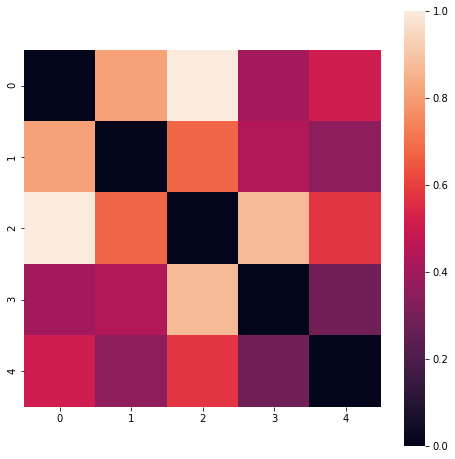

In [40]:
# visual inspection
import seaborn as sns

ax = sns.heatmap(D, linewidth = 0, square = True)
plt.show('original.png')
plt.close()

Working with a hypothesis that the kernel weights *might* relate to the edges, we only know that the side of the input, which I assume to be the rows, is ordered as the inputs in a way that matches the distance matrix. The columns, however, could be in any arbitrary order even if they really did represent individual vertices (we have no compelling reason to assume this would be the case, but that does not stop us from checking it out).

If the weights *were* related to the edges, then we would see that minimum diagonal since the distance matrix has all zeroes in the diagonal. If we look at the weights as they are, this is clearly not the case.

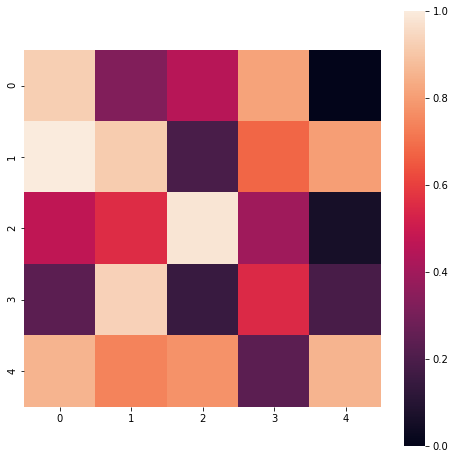

In [41]:
ax = sns.heatmap(I, linewidth = 0, square = True)
plt.show('inferred.png')
plt.close()

We could try to reorder the columns to put the smallest possible elements in the diagonal to see if that helps.

In [42]:
def mindiag(matrix): # reorder the columns to put minimal elements on
    n, m = matrix.shape
    assert n == m # square only
    ordered = dict()
    used = set()
    high = np.max(matrix) * 2
    while len(ordered) < n:
        low = high
        pick = None
        for x in range(n): # rows
            if not x in ordered:
                for y in range(n): # columns
                    if not y in used:
                        v = matrix[x][y]
                        if v < low:
                            low = v
                            pick = (x, y)
        (x, y) = pick
        ordered[x] = matrix[:, y]
        used.add(y)
    return np.column_stack([ ordered[v] for v in range(n) ])
Io = mindiag(normalize(I))                                          

We can redo the visualization to see if there is any hope to the cause there.

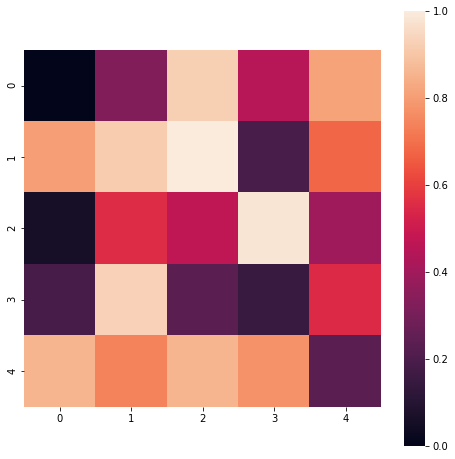

In [43]:
ax = sns.heatmap(Io, linewidth = 0, square = True)
plt.show('reordered.png')
plt.close()

It's a little better, but not much. It does have *some* symmetry now, as the distance matrix does, but not a lot.

We can also try statistical means to explore for possible relations. Let's try the Pearson correlation coefficient.

In [44]:
i = Io.flatten() # 1D
d = D.flatten() # 1D
corr = np.corrcoef(i, d)[0][-1]
print(f'The correlation is {corr}') # nope 

The correlation is 0.22073475107305046


Well, for smaller graphs, kinda; larger ones are pretty far off. 

It _knows_ the edges somehow. Not magic, but math. It could be a *non-linear* relation. 

Would it know them even better if it were actually a deep model and we would let it map out each step of the way?

In [45]:
deep = Sequential() # kinda like Arturo's bolzmann machines
deep.add(Dense(n, input_dim = n, activation = 'relu')) # input and first hidden:
for i in range(n - 1): # another n - 1 hidden layers
    deep.add(Dense(n, activation = 'relu'))
deep.add(Dense(1, activation = 'sigmoid')) # output the 0/1

second = examine(m, X, y, testX, testy)

# is it better?
print(f'The first one had {first[0]:.3f} loss and {first[1]:.3f} accuracy')
print(f'This one had {second[0]:.3f} loss and {second[1]:.3f} accuracy')     

Epoch 1/20
2/2 [==============================] - 0s 2ms/step - loss: 1.1915 - accuracy: 0.6923
Epoch 2/20
2/2 [==============================] - 0s 1ms/step - loss: 1.1800 - accuracy: 0.6923
Epoch 3/20
2/2 [==============================] - 0s 2ms/step - loss: 1.1672 - accuracy: 0.6923
Epoch 4/20
2/2 [==============================] - 0s 1ms/step - loss: 1.1521 - accuracy: 0.6923
Epoch 5/20
2/2 [==============================] - 0s 3ms/step - loss: 1.1423 - accuracy: 0.6923
Epoch 6/20
2/2 [==============================] - 0s 2ms/step - loss: 1.1339 - accuracy: 0.6923
Epoch 7/20
2/2 [==============================] - 0s 2ms/step - loss: 1.1221 - accuracy: 0.6923
Epoch 8/20
2/2 [==============================] - 0s 2ms/step - loss: 1.1103 - accuracy: 0.6923
Epoch 9/20
2/2 [==============================] - 0s 2ms/step - loss: 1.1035 - accuracy: 0.6923
Epoch 10/20
2/2 [==============================] - 0s 2ms/step - loss: 1.0946 - accuracy: 0.6923
Epoch 11/20
2/2 [======================

We can also look at what this is like on the inside. (This is the visualization that likes to open in a window, non-jupyter friendly).

In [46]:
visualizer(deep, filename = 'deep', format = 'png', view = True)

We can even look at the kernel weights in each layer.

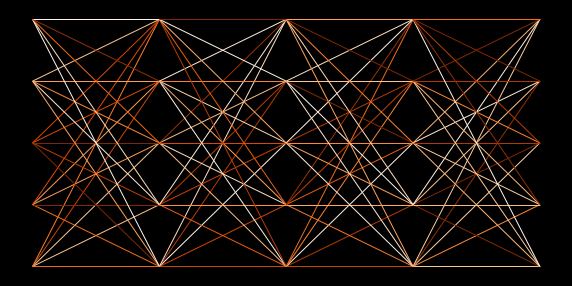

In [47]:
# since we do not know how in maps the vertices
# on the layers internally, we can but visualize the structure
W = deep.get_weights()
Gd = Graph()
dpos = dict()
for layer in range(n):
    w = normalize(W[2 * layer])
    for v in range(n):
        vl = f'{layer}.{v}'
        Gd.add_node(vl)
        dpos[vl] = (layer, v) # position by layer
        if layer > 0: # link it to the previous layer, all positions
            for u in range(n):
                Gd.add_edge(vl, f'{layer-1}.{u}', weight = w[v][u]) # we use the kernel matrix

# set up how we want the visualization to look
plt.rcParams['figure.figsize'] = (2 * n, n) # we need this _wide_
opt = { 'with_labels': False, 'node_size': 50, 'width': 1 }
fig, ax = plt.subplots()
from networkx import get_edge_attributes, get_node_attributes
wm = get_edge_attributes(Gd, 'weight').values()
wn = list(get_node_attributes(Gd, 'weight').values())
draw(Gd, pos = dpos,
    cmap = plt.get_cmap('Blues'), # color the nodes with their weights
     edge_cmap = plt.get_cmap('Oranges'), # the same palette works
     node_color = wn, # node colors from weights 
     edge_color = wm, # edge colors from weights
     **opt)
ax.set_facecolor('black')
fig.set_facecolor('black')
ax.axis('off')
plt.show() # somewhere in there, our edges are hiding :)
plt.close()   

# Homework

It would be cool to be able to *extract* the edge data from there since it is very clearly inferred in one way or another. It should be easier to figure out what is going on if we used a graph in which we always know what the optimal route is and how much worse the others are. So, let's place the vertices along a circle.

In [48]:
C = Graph() # we make a circle of n vertices  
cpos = dict()     
from math import pi, sin, cos 
da = 2 * pi / n
sep = 200 # how far apart along the circle the vertices go
radius = sep / da     
noise = 0.05 # how noisy it should be (as a fraction of [-radius, radius])   
                                                                                      
def wiggle(magnitude, radius):    
    return radius + magnitude * radius * (2 * random() - 1)  
                                                                                      
for v in range(n):            
    angle = v * da       
    x = wiggle(noise, radius) * cos(angle)    
    y = wiggle(noise, radius) * sin(angle) 
    p = (x, y)  
    C.add_node(v)    
    cpos[v] = (x, y)    
                                                                                      
ec = dict() 
for v in range(n):           
    (vx, vy) = cpos[v]
    for u in range(n):                                
        (ux, uy) = cpos[u]
        d = sqrt((vx - ux)**2 + (vy - uy)**2)     
        C.add_edge(v, u)               
        ec[(v, u)] = d

Let's draw it to see how it looks.

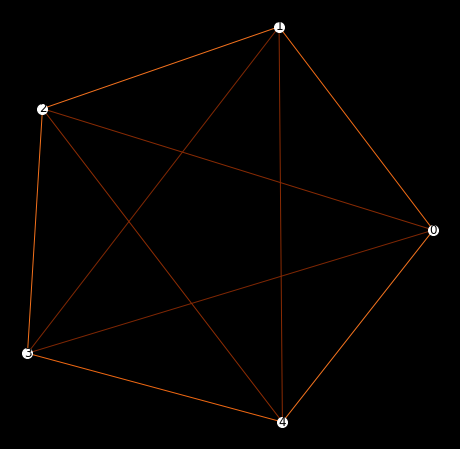

In [49]:
opt = { 'node_color': 'white', 'font_color': 'black' }  
opt['with_labels'] = n <= 30 
opt['node_size'] = sep // 2  
opt['width'] = max(4 - magn, 1) 
plt.rcParams['figure.figsize'] = (unit, unit) 
if n <= 100:                      
    fig, ax = plt.subplots()  
    draw(C, pos = cpos,  
         edge_cmap = plt.get_cmap('Oranges'), 
         edge_color = [ ec[(v, w)] for v, w in C.edges() ], 
         **opt) 
    ax.set_facecolor('black')   
    fig.set_facecolor('black')
    ax.axis('off')  
    plt.show() 
    plt.close() 

The optimum here is be obvious as long as the noise is low; explore with different kinds of DL models to see you explain how the fitted model represents the graph.

You can either write your own code or reuse bits and pieces from the code above to test things out. Let me know what you find out :)